In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
# load data
df_ori = pd.read_csv('../data/rawdata/labeled_data.csv')
# check loaded data
df_ori.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
'''
the columns that matter: class
''' 
label = df_ori['class']
df_ori.rename(columns={'tweet':'text',
                      'class':'category'}, inplace=True)

text = df_ori['text']
cat = df_ori['category'].map({0:'hate_speech', 1:'offensive_lang',2:'neither'})
df = pd.concat([text,cat,label],axis=1)
df.rename(columns={'class':'label'}, inplace=True)

In [4]:
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_lang,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_lang,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_lang,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_lang,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_lang,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_lang,1
24781,youu got wild bitches tellin you lies,offensive_lang,1


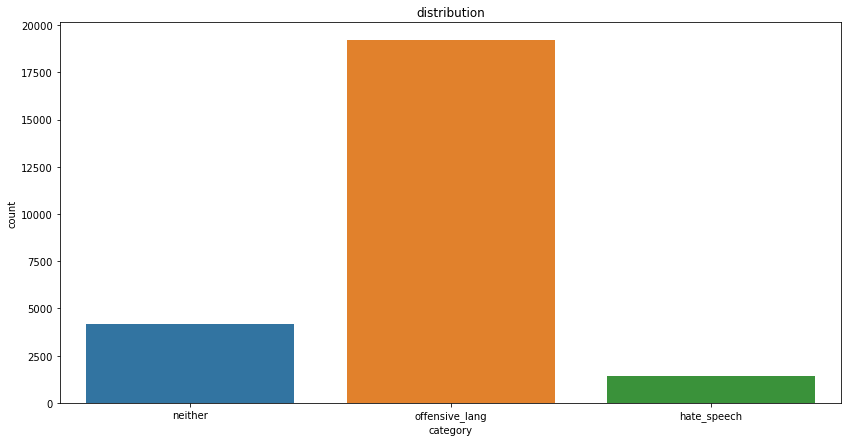

In [7]:
fig = plt.figure(figsize=(14,7))
plt.title('distribution')
graph = sns.countplot(x='category', data=df)
for category in graph.patches:
    height = category.get_height()

nlp text preprocessing

In [18]:
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
import gensim
import re

In [19]:
# clean text so that we dont waste processing time on unecessary words
spacey = spacy.load('en_core_web_sm')

# overkill
stopwords_sp = spacey.Defaults.stop_words
stopwords_gensim = gensim.parsing.preprocessing.STOPWORDS

stopwords_nltk = stopwords.words('english')
# add custom stop words
custom_stop_words = ['rt']
stopwords_nltk.extend(custom_stop_words)

stopwords = set(set(stopwords_sp) | set(stopwords_nltk) | set(stopwords_gensim))

In [20]:
def clean(text):
    text = text.lower()
    string = ''
    
    text=re.sub(r"[-()\"#!@$%^&*{}?.,:]"," ",text)
    text=re.sub(r"\s+"," ",text)
    text=re.sub('[^A-Za-z0-9]+',' ', text)
    
    for word in text.split():
        if word not in stopwords:
            string += WordNetLemmatizer().lemmatize(word)+ ' '
    return string

In [21]:
df['text']=df['text'].apply(clean)

In [26]:
df.to_csv('./cleandata/cleaned.csv')

# Suggested dataset splitting

In [22]:
df

,text,category,label,data_type
0,mayasolovely woman complain cleaning house amp...,neither,2,test
1,mleew17 boy dat cold tyga dwn bad cuffin dat h...,offensive_lang,1,train
2,urkindofbrand dawg 80sbaby4life fuck bitch sta...,offensive_lang,1,train
3,c g anderson viva based look like tranny,offensive_lang,1,train
4,shenikaroberts shit hear true faker bitch told...,offensive_lang,1,train
...,...,...,...,...
24778,muthaf lie 8220 lifeasking 20 pearl corey eman...,offensive_lang,1,train
24779,gone broke wrong heart baby drove redneck crazy,neither,2,train
24780,young buck wanna eat dat nigguh like aint fuck...,offensive_lang,1,train
24781,youu got wild bitch tellin lie,offensive_lang,1,train


In [23]:
from sklearn.model_selection import train_test_split

# split into train and test
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

# split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

df.groupby(['category', 'label', 'data_type']).count()

text
category       label data_type       
hate_speech    0     test         143
                     train       1158
                     val          129
neither        2     test         416
                     train       3372
                     val          375
offensive_lang 1     test        1920
                     train      15543
                     val         1727

In [25]:
df_train = df.loc[df['data_type']=='train']
df_val = df.loc[df['data_type']=='val']
df_test = df.loc[df['data_type']=='test']